In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_temptations_functions import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial

import statsmodels.api as sm

import pickle

In [2]:
planting(456)

#### *Load Data*

In [3]:
cyto_data = pd.read_csv("flow_prop_canonical.csv")

In [4]:
# rename IgM+IgD+CD27+ & IgM+IgD-CD27+ as unswitched memory
cyto_data = cyto_data.replace('IgM+IgD+CD27+','unswitched_mem')
cyto_data = cyto_data.replace('IgM+IgD-CD27+','unswitched_mem')

cyto_data = cyto_data.groupby(['PatientID', 'Timepoint', 'Spike', 'cell_type', 'variable'], as_index = False).sum()

##### *Process Data: All patients*

In [5]:
cyto_sPos = cyto_data[cyto_data.Spike == "S+"]

# state names
celltype_list = ['Trans/Naive', 'unswitched_mem','DN', 'switched_mem', 'plasma']

# get them all together for residuals
 # extract the sampled time points
timepoint_list_allP = np.sort(cyto_sPos.Timepoint.unique())
    
# transform into state count
cyto = formatCount(cyto_sPos, timepoint_list_allP, 'Timepoint', 'cell_type', timemarker='d', isotype_list=celltype_list, proportion_col_name='value')

# transform into nump array for calculations
cyto = cyto.to_numpy()

In [6]:
def eqTin_donors(df, donor_col = "PatientID", timepoint_col = "Timepoint", state_col_name = "cell_type", state_list = celltype_list, iscount=True, proportion_col_name = None):
    N_donors = {}
    T_donors = {}
    u_donors = {}

    donors = df[donor_col].unique()
    timeCourse = {}

    for d in donors:
    
        # donor filter
        df_donor = df[df[donor_col] == d]
    
        # extract the sampled time points
        timepoint_list = np.sort(df_donor[timepoint_col].unique())
        timeCourse[d] = timepoint_list.shape[0] 
    
        # transform into state count
        df_donor = formatCount(df_donor, timepoint_list, timepoint_col, state_col_name, timemarker='d', isotype_list=state_list, proportion_col_name=proportion_col_name)

        # transform into nump array for calculations
        donor = df_donor.to_numpy()
    
        N, T, k = eqTin(donor, proportion=iscount,giveK=True)
        N_donors[d] = N
        T_donors[d] = T
        u_donors[d] = np.diff(timepoint_list)
    return N_donors, T_donors, u_donors

N_donors, T_donors, u_donors = eqTin_donors(cyto_sPos, iscount=False, proportion_col_name='value')

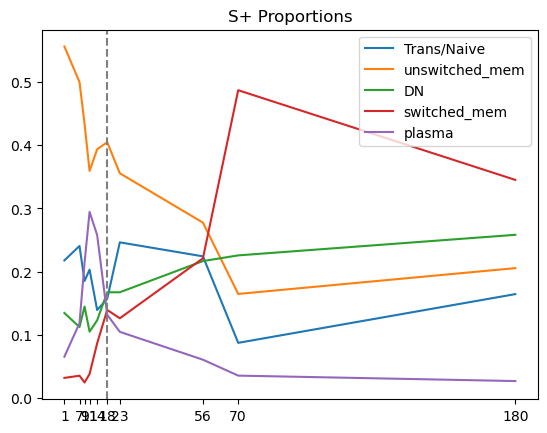

In [7]:
for i in range(5):
    plt.plot(timepoint_list_allP,cyto[i,:], label = celltype_list[i])
    plt.xticks(timepoint_list_allP)
plt.axvline(x=18, linestyle = '--', color = 'grey')
plt.title('S+ Proportions')
plt.legend()
plt.show()

##### *Q Template & Functions*

In [8]:
Q_template = np.array([[1.,2.,3.,4.,5.], # no returning to Naive state
                      [0,2.,3.,4.,5.], # unswitched memory
                      [0,2.,3.,4.,5.], # DNs
                      [0,0,3,4.,5.],  # switched memory cannot become M_mem or IgD- as they are both IgM and this is switched but can be a DN
                      [0,0,0,0,0]]) # absorbing state = plasma

In [9]:
def genTheta(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range((k-1)):
        for j in range(1,k):
            Q_0[i,j] = rand.uniform(1e-12,ub)
        
        # C_mem structural zeros
        if i == (k-2):
            Q_0[i,1] = 0.
            
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij  
        
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    result = theta_0

    return result

def genTheta_ingress(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range((k-1)):
        for j in range(1,k):
            Q_0[i,j] = rand.uniform(1e-12,ub)
        
        # C_mem structural zeros
        if i == (k-2):
            Q_0[i,1] = 0.
            
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij 
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    
    b0 = rand.uniform(1e-12,1)
    
    result = np.append(theta_0,b0)

    return result

def genTheta_baseline(k, ub = 2e-1, **kwargs):
    # create starting intensity trans. mat
    Q_0 = np.zeros((k,k))

    for i in range((k-1)):
        for j in range(1,k):
            Q_0[i,j] = rand.uniform(1e-12,ub)
        
        # C_mem structural zeros
        if i == (k-2):
            Q_0[i,1] = 0.
            
        # sum our row
        sum_q_ij = sum(Q_0[i,])
    
        # assign ii based on the constraint that the row must equal 0
        Q_0[i,i] = -sum_q_ij 
    theta_0 = Q_0[np.nonzero(Q_0[:,:-1])]
    
    b0 = [rand.uniform(-1,1) for i in range(k)]
    
    result = np.append(theta_0,b0)

    return result

## Spike Positive

In [10]:
# set param
k = Q_template.shape[0]
xterm = 1e-15
gterm = 1e-15
max_iter = 5e4
numCores = 10
mc_iter = 15
n_param = len(np.nonzero(Q_template[:,:-1])[0])

Regular bounds &

In [11]:
q_lb = np.zeros(n_param)
q_ub = np.zeros(n_param)

q_diag = np.zeros((k-1))

q_diag[-1] = 11
for n in range((k-2)):
    q_diag[n] = (k-1) * n
    
for n in range(n_param):
    if n in q_diag:
        q_lb[n] = -np.inf
        q_ub[n] = 0
    else:
        q_lb[n] = 0 
        q_ub[n] = np.inf

reg_bounds = Bounds(q_lb, q_ub)

row_eq = np.zeros((((k-1),n_param)))

row_eq[0,:(k-1)] = 1
row_eq[-1,-2:] = 1

for n in range(1,(k-2)):
    i = int(3*n + 1)
    j = int(3*n + 4)
    
    row_eq[n,i:j] = 1
    
reg_con = LinearConstraint(row_eq,  ub = np.zeros((k-1)), keep_feasible=True)

In [12]:
optimiserArgs = {'costFunc': calc_cost_donors, 'args': (N_donors, T_donors, k, u_donors, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 10}
options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}

#theta_allP, optError_allP = parallel_mc_optimiser(mc_iter, numCores, n_param, theta_generator=genTheta, optimiserArgs=optimiserArgs, options=options, progress_bar = True)

In [13]:
#filename = "cytoResults/cyto_allTime_allDonor_5state.pkl"
#with open(filename, 'wb') as f:
 #   pickle.dump([theta_allP,optError_allP], f)

In [14]:
filename = "cytoResults/cyto_allTime_allDonor_5state.pkl"
with open(filename, 'rb') as f:
    [theta_allP, optError_allP] = pickle.load(f)

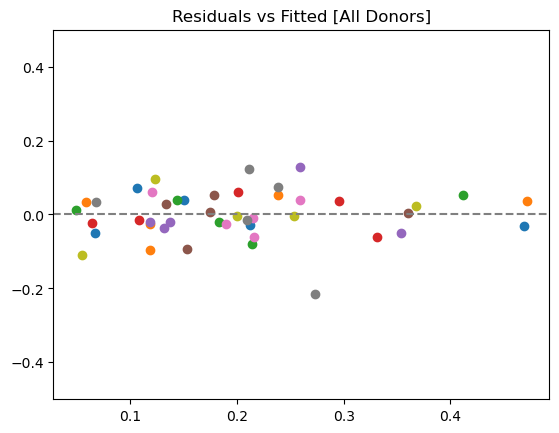

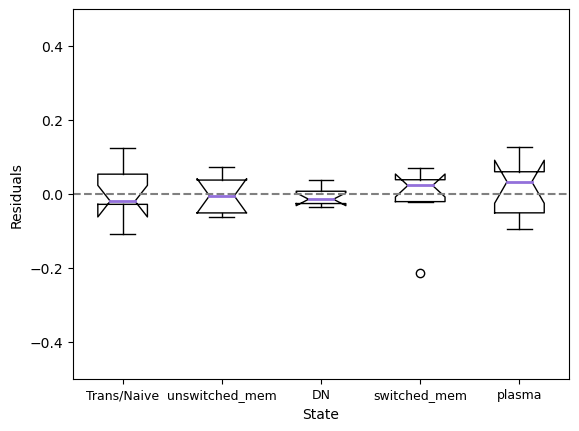

Average abs. residual:  0.0489504609968895


In [15]:
## calculate residuals on a perDonor basis
# residuals
N, T, k = eqTin(cyto, proportion=False)
timeCourse_allP = timepoint_list_allP.shape[0]
u = np.diff(timepoint_list_allP)

new = theta_allP
S1_Q = theta_to_Q(new, k, Q_template)

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - N[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.5,.5)
plt.title("Residuals vs Fitted [All Donors]")
plt.show() 

xseq = []
for i in range(1,timeCourse_allP): xseq.append(str(i))

plt.boxplot(epsi,
            notch=True,
            medianprops=dict(color="mediumpurple", linewidth=2))
plt.xticks(range(1, 6), celltype_list, fontsize=9)
plt.xlabel("State")
plt.ylabel("Residuals")
plt.ylim(-.5,.5)
plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.show()
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [16]:
pd.DataFrame(S1_Q, index=celltype_list, columns=celltype_list)

,Trans/Naive,unswitched_mem,DN,switched_mem,plasma
Trans/Naive,-0.004171,0.004171,1.661789e-10,1.835241e-09,9.865427e-11
unswitched_mem,0.000000,-0.038309,2.057921e-02,1.740121e-02,3.289618e-04
DN,0.000000,0.028887,-7.474078e-02,4.585400e-02,4.295330e-10
switched_mem,0.000000,0.000000,3.986847e-02,-4.172616e-02,1.857685e-03
plasma,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00


In [17]:
new = theta_allP
celltype_names = ['Trans/Naive', 'IgM_mem','DN', 'C_mem', 'plasma']
S1_Q = theta_to_Q(new, k, Q_template)
pd.DataFrame(transMat(S1_Q, 2), index=celltype_names, columns=celltype_names)

,Trans/Naive,IgM_mem,DN,C_mem,plasma
Trans/Naive,0.991693,0.008000,0.000163,0.000142,0.000003
IgM_mem,0.000000,0.927343,0.038079,0.033881,0.000697
DN,0.000000,0.051693,0.865450,0.082681,0.000177
C_mem,0.000000,0.002079,0.071099,0.923253,0.003569
plasma,-0.000000,-0.000000,0.000000,-0.000000,1.000000


In [18]:
# transform residual vector
Y = np.array([])
X = np.empty(0)

for t in range(1,T-1):
    Y = np.append(Y,epsi[t,:], axis=0)

    features = epsi[t-1,:]
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=['Residual_tm1'])
df = pd.get_dummies(data=df, drop_first=True)
X = df

In [19]:
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.08951
Date:                Wed, 05 Mar 2025   Prob (F-statistic):              0.766
Time:                        16:10:19   Log-Likelihood:                 52.621
No. Observations:                  40   AIC:                            -101.2
Df Residuals:                      38   BIC:                            -97.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.011      0.016   

In [20]:
# sojourn time
q_ii = np.diagonal(S1_Q)

pd.DataFrame({'Parameter': celltype_names, 'Holding Time': (lambda i: 1/(-q_ii[i]))(range(k))})

/tmp/ipykernel_1042500/1519030099.py:4: RuntimeWarning: divide by zero encountered in divide
  pd.DataFrame({'Parameter': celltype_names, 'Holding Time': (lambda i: 1/(-q_ii[i]))(range(k))})


,Parameter,Holding Time
0,Trans/Naive,239.754773
1,IgM_mem,26.103263
2,DN,13.379577
3,C_mem,23.965781
4,plasma,inf


In [21]:
print(pd.DataFrame(transMat(S1_Q, u[0]), columns=celltype_list, index=celltype_list))

                Trans/Naive  unswitched_mem        DN  switched_mem    plasma
Trans/Naive        0.975285        0.022144  0.001318      0.001225  0.000027
unswitched_mem     0.000000        0.803164  0.098674      0.095843  0.002320
DN                 0.000000        0.125536  0.669191      0.203880  0.001393
switched_mem       0.000000        0.015340  0.171445      0.803245  0.009970
plasma            -0.000000       -0.000000  0.000000     -0.000000  1.000000


#### Bootstrap: Resample residuals

In [ ]:
B = 1500
startIteration = 1251
optimiserArgs = {'costFunc': calc_cost_donors, 'args': (N_donors, T_donors, k, u_donors, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 10}
options = {'hessian': None, 'xterm': xterm, 'gterm': gterm, 'max_iter': max_iter}

mcArgs = {'mciter': mc_iter, 'n_cores': numCores}

In [23]:
# make checkpoint theta_boot file
#theta_boot = np.zeros((B,n_param))
#checkpoint_filename = "cytoResults/cytoBS_checkpoint_theta_boot.pkl"
#with open(checkpoint_filename, 'wb') as f:
#    pickle.dump(theta_boot, f)

In [24]:
# load old check point into new checkpoint
theta_boot = np.zeros((B,n_param))
checkpoint_filename = "cytoResults/cytoBS_checkpoint_theta_boot.pkl"
with open(checkpoint_filename, 'rb') as f:
    theta_boot = pickle.load(f)
    
with open(checkpoint_filename, 'wb') as f:
    pickle.dump(theta_boot,f)

In [25]:
residResamp=bootstrap_resResamp_perDonor(point_estimate=theta_allP, n_bootstrapSamples=B, n_param=n_param, theta_generator=genTheta, mcArgs=mcArgs, optimiserArgs=optimiserArgs, options=options, checkpoint_filename=checkpoint_filename, startIteration=startIteration)

 16% (120 of 743) |     | Elapsed Time: 5 days, 4:00:34 ETA:  29 days, 14:59:00
 16% (121 of 743) |     | Elapsed Time: 5 days, 5:00:04 ETA:  25 days, 16:45:53
/home/cc/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/cc/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
 16% (122 of 743) |     | Elapsed Time: 5 days, 6:13:17 ETA:  31 days, 13:50:17
/home/cc/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/cc/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/cc/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
 16% (123 of 743) |      | Elapsed 

In [ ]:
filename = "cytoResults/cytoBS_allTime_allDonor_5state.pkl"
with open(filename, 'wb') as f:
    pickle.dump(residResamp, f)

In [ ]:
filename = "cytoResults/cytoBS_allTime_allDonor_5state.pkl"
with open(filename, 'rb') as f:
    residResamp = pickle.load(f)